In [1]:
#% matplotlib inline

from datetime import datetime 
import h5py
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
cmap = cm.get_cmap('Blues')
import random
from scipy import signal, cluster, stats
from multiprocessing import Pool
from sklearn.cluster import KMeans
import scipy as sp
from scipy import linalg
from sklearn.decomposition import SparsePCA
from sklearn.mixture import GaussianMixture
import cairosvg
from PIL import Image

In [2]:
from matplotlib import animation, rc
from IPython.display import HTML

In [3]:
def get_svg_looming_stimulus(rf_spatial_extent, stimulus_velocity,
                             real_time_lag, time_points, space_per_pixel):
    
    temporal_conversion = time_points / real_time_lag  # From seconds to pixel.
    spatial_conversion = 1 / space_per_pixel  # From um to pixel.
    
    #get the width of image in pixels (from space)
    image_space_pixels = rf_spatial_extent * spatial_conversion
    
    #get the length of image in pixels (from time)
    distance_traveled = rf_spatial_extent/2 #because it expands in both directions
    #WARNING: HERE VELOCITY REFERS TO EXPANSION OF ONE SIDE, DIFFERENT FROM QDSPY
    total_time = distance_traveled/stimulus_velocity
    total_time_pixels = total_time * temporal_conversion
    
    return (total_time_pixels, image_space_pixels)


In [4]:
def convolved_dsis_looming(velocity, convolution_params):
    convolution_params['stimulus_velocity'] = velocity # WARNING altering this to play around with velocity tuning
    convolution_params['distance_covered'] = 340 #was 300
    
    if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
        space_per_pixel = space_per_pixelx
    else:
        space_per_pixel = space_per_pixely


    time_px, space_px = get_svg_looming_stimulus(
        convolution_params['distance_covered'],
        convolution_params['stimulus_velocity'],
        real_time_lag,
        time_points,
        space_per_pixel
    )

    #     #get coordinates of the triangle
    #     x_top = 0
    #     y_top = image_space_pixels/2
    #     x_bottom_left = total_time_pixels
    #     y_bottom_left = 0
    #     x_bottom_right = total_time_pixels
    #     y_bottom_right = image_space_pixels

    #On
    string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
        <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
        <polygon points="{6},0 0,{7} {8},{9}" fill="white" />
    </svg>""".format(space_px, time_px, space_px, time_px, space_px, time_px, 
                    space_px/2, time_px, space_px, time_px)

    folder_str = 'Data/'
    file_name = str(1)
    name_svg = folder_str + file_name + ".svg"
    name_png = folder_str + file_name + ".png"

    new_file = open(name_svg, "wt")
    new_file.write(string_svg)
    new_file.close()

    cairosvg.svg2png(url=name_svg, write_to=name_png)

    stimulus_image_On = np.array(Image.open(name_png).convert('L'))
    stimulus_image_On_rev = np.flip(stimulus_image_On, axis=0)

    #Off

    stimulus_image_Off = stimulus_image_On * -1
    stimulus_image_Off_rev = np.flip(stimulus_image_Off, axis=0)
    
    #get convolved responses

    # cluster_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,]
    dsi = np.zeros(13)
    dsi_off = np.zeros(13)

    fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))

    for i, clust in enumerate(ipl_depth_order):
        
        # get the necessaries
        # spline = (NoiseSplineRF2 & key).fetch1('spl')
        spline = average_filters[:,11:28,clust] #was using 11:27
        edge_buffer = 15 #(ConvolutionKernelParams() & key).fetch1('edge_buffer')
        
        #make final stimulus images for the polarity of the cell (on vs. off)
        if polarity[clust] == -1:
            stim_image_polarity = stimulus_image_Off
            stim_image_polarity_rev = stimulus_image_Off_rev
        else:
            stim_image_polarity = stimulus_image_On#*polarity[clust]
            stim_image_polarity_rev = stimulus_image_On_rev#*polarity[clust]

        kernel_type = 'full'#(ConvolutionKernelParams() & key).fetch1('kernel_type')
        # set up and crop the kernel
        kernel_length = stim_image_polarity.shape[1]  # needs to be the same length as the stimulus

        # get the location of the RF center in the kernel
        spline_temp = spline[edge_buffer:-edge_buffer, :]
        index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
        peak_y = index_max[1]

        # crop the kernel depending on the type of experiment
        if kernel_type == 'right':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y - 1):np.int(peak_y + kernel_length - 1)]
        elif kernel_type == 'left':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
        elif kernel_type == 'full':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         0:kernel_length]  # should be full kernel, just adding space range just in case
        elif kernel_type == 'centered':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         np.int(np.floor(peak_y - kernel_length / 2)):np.int(np.floor(peak_y + kernel_length / 2))]
        else:
            spline_cut = spline  # just to make the code happy, this should never be the option
        # can code in other possibilities here...


            
        # check whether cut spline is big enough
        space_length = spline_cut.shape[1]
        if kernel_length == space_length:
            empty_flag = 0
            # setup output variables
            convolved_response = np.zeros((spline_cut.shape[0] + stim_image_polarity.shape[0] - 1, spline_cut.shape[1]))
            convolved_response_rev = np.zeros((spline_cut.shape[0] + stim_image_polarity.shape[0] - 1, spline_cut.shape[1]))

            # loop through x positions and convolve
            for x_position in range(stim_image_polarity.shape[1]):
                ker = np.flip(spline_cut[:, x_position])
                img = stim_image_polarity[:, x_position]
                img2 = stim_image_polarity_rev[:, x_position]
                # and then convolve these two
                convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
                convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
        else:
            empty_flag = 1
            convolved_response = []
            convolved_response_rev = []
        
        response = np.sum(convolved_response, axis=1)
        response_rev = np.sum(convolved_response_rev, axis=1)
        max_response = np.amax(response[:300])
        max_response_rev = np.amax(response_rev[:300])
        dsi[clust] = (max_response - max_response_rev) / (max_response + max_response_rev)
        ax[i].plot(response, color='k') #*polarity[clust]
        ax[i].plot(response_rev, color='b') #*polarity[clust]
        ax[i].axhline(color='k', linestyle='dotted')
        ax[i].set_yticklabels([])
        ax[i].set_xticklabels([])
        ax[i].axis('off')
#     if velocity==400:
# #         Figpath = 'Fig_temp/'
# #         savename = Figpath+"Convolved_responses_looming_1000um_s.pdf"
# #         plt.savefig(savename, transparent=True, bbox_inches='tight')
    
    return dsi#, dsi_off

In [5]:
# enhancing the surround for Off clusters

def convolved_dsis_looming_adjust(velocity, convolution_params):

    convolution_params['stimulus_velocity'] = velocity # WARNING altering this to play around with velocity tuning
    convolution_params['distance_covered'] = 340 #was 300
    if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
        space_per_pixel = space_per_pixelx
    else:
        space_per_pixel = space_per_pixely


    time_px, space_px = get_svg_looming_stimulus(
        convolution_params['distance_covered'],
        convolution_params['stimulus_velocity'],
        real_time_lag,
        time_points,
        space_per_pixel
    )

    #On
    string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
        <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
        <polygon points="{6},0 0,{7} {8},{9}" fill="white" />
    </svg>""".format(space_px, time_px, space_px, time_px, space_px, time_px, 
                    space_px/2, time_px, space_px, time_px)

    folder_str = 'Data/'
    file_name = str(1)
    name_svg = folder_str + file_name + ".svg"
    name_png = folder_str + file_name + ".png"

    new_file = open(name_svg, "wt")
    new_file.write(string_svg)
    new_file.close()

    cairosvg.svg2png(url=name_svg, write_to=name_png)

    stimulus_image_On = np.array(Image.open(name_png).convert('L'))
    stimulus_image_On_rev = np.flip(stimulus_image_On, axis=0)

    #Off

    stimulus_image_Off = stimulus_image_On * -1
    stimulus_image_Off_rev = np.flip(stimulus_image_Off, axis=0)
    
    #get convolved responses

    # cluster_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,]
    dsi = np.zeros(13)
    dsi_off = np.zeros(13)

    fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))

    for i, clust in enumerate(ipl_depth_order):
        
        spline = average_filters[:,11:28,clust] #was using 12:27
        if polarity[clust]==-1:
            spline = np.where(spline>0, spline*3, spline)#try enhancing the surround
            spline[:, 7:10] = average_filters[:,18:21,clust]
        else:
            spline = np.where(spline<0, spline*3/2, spline)
            spline[:, 7:10] = average_filters[:,18:21,clust]
        
        edge_buffer = 15 #(ConvolutionKernelParams() & key).fetch1('edge_buffer')
        
        #make final stimulus images for the polarity of the cell (on vs. off)
        if polarity[clust] == -1:
            stim_image_polarity = stimulus_image_Off
            stim_image_polarity_rev = stimulus_image_Off_rev
        else:
            stim_image_polarity = stimulus_image_On#*polarity[clust]
            stim_image_polarity_rev = stimulus_image_On_rev#*polarity[clust]

        kernel_type = 'full'#(ConvolutionKernelParams() & key).fetch1('kernel_type')
       
        # set up and crop the kernel
        kernel_length = stim_image_polarity.shape[1]  # needs to be the same length as the stimulus

        # get the location of the RF center in the kernel
        spline_temp = spline[edge_buffer:-edge_buffer, :]
        index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
        peak_y = index_max[1]

        # crop the kernel depending on the type of experiment
        if kernel_type == 'right':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y - 1):np.int(peak_y + kernel_length - 1)]
        elif kernel_type == 'left':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
        elif kernel_type == 'full':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         0:kernel_length]  # should be full kernel, just adding space range just in case
        elif kernel_type == 'centered':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         np.int(np.floor(peak_y - kernel_length / 2)):np.int(np.floor(peak_y + kernel_length / 2))]
        else:
            spline_cut = spline  # just to make the code happy, this should never be the option
        # can code in other possibilities here...

        # check whether cut spline is big enough
        space_length = spline_cut.shape[1]
        if kernel_length == space_length:
            empty_flag = 0
            # setup output variables
            convolved_response = np.zeros((spline_cut.shape[0] + stim_image_polarity.shape[0] - 1, spline_cut.shape[1]))
            convolved_response_rev = np.zeros((spline_cut.shape[0] + stim_image_polarity.shape[0] - 1, spline_cut.shape[1]))

            # loop through x positions and convolve
            for x_position in range(stim_image_polarity.shape[1]):
                ker = np.flip(spline_cut[:, x_position])
                img = stim_image_polarity[:, x_position]
                img2 = stim_image_polarity_rev[:, x_position]
                # and then convolve these two
                convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
                convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
        else:
            empty_flag = 1
            convolved_response = []
            convolved_response_rev = []
        
        response = np.sum(convolved_response, axis=1)
        response_rev = np.sum(convolved_response_rev, axis=1)
        max_response = np.amax(response[:300])
        max_response_rev = np.amax(response_rev[:300])
        dsi[clust] = (max_response - max_response_rev) / (max_response + max_response_rev)
        ax[i].plot(response, color='k') #*polarity[clust]
        ax[i].plot(response_rev, color='b') #*polarity[clust]
        ax[i].axhline(color='k', linestyle='dotted')
        ax[i].set_yticklabels([])
        ax[i].set_xticklabels([])
        ax[i].axis('off')
#     if velocity==400:
#         print("response shape is", response.shape)
#         Figpath = 'Fig_temp/'
#         savename = Figpath+"Convolved_responses_looming_1000um_s_enhanced.pdf"
#         plt.savefig(savename, transparent=True, bbox_inches='tight')
    
    return dsi#, dsi_off

In [6]:
#pull the convolution parameters for modeling
convolution_params = {}
file = h5py.File('Data/FigS06_model.hdf5', 'r')
dict_group_load = file['convolution_params']
dict_group_keys = dict_group_load.keys()
for k in dict_group_keys:
    convolution_params[k]= np.float(dict_group_load[k][0])
    
real_time_lag = convolution_params['real_time_lag']
time_points = convolution_params['time_points']
space_per_pixelx = convolution_params['space_per_pixelx']
space_per_pixely = convolution_params['space_per_pixely']

In [7]:
ipl_depth_order = [0, 3, 9, 7, 11, 2, 8, 5, 6, 1, 10, 12, 4]
polarity = [1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1]
average_filters = np.load('Data/average_filters_by_cluster.npy')

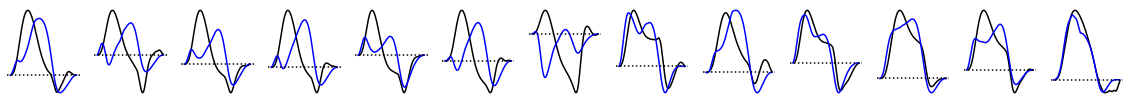

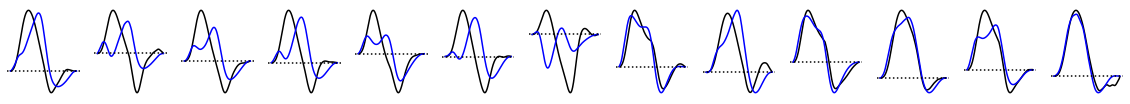

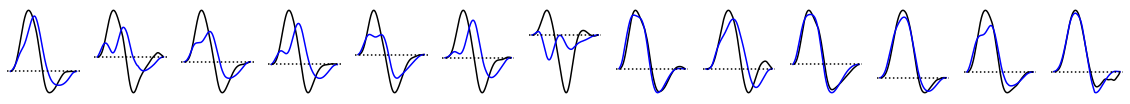

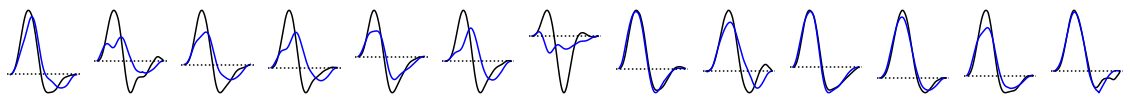

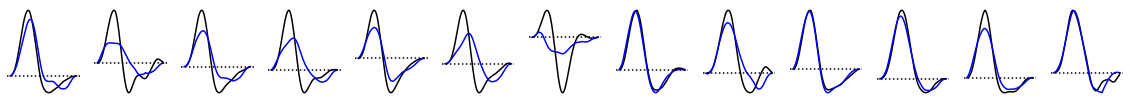

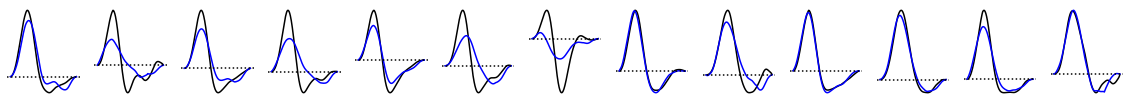

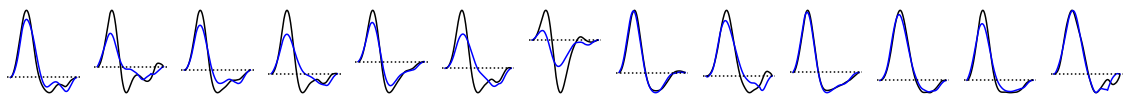

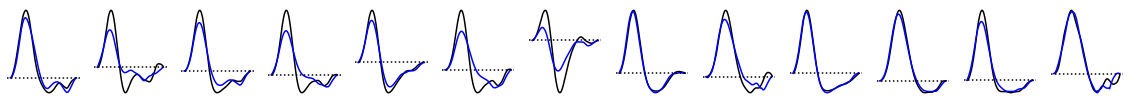

In [8]:
# run models
velocities = [250, 400, 600, 800, 1000, 1200, 1600, 2000]
dsi_all_all_looming = np.zeros((len(velocities), 13))

for i, velocity in enumerate(velocities):
    dsi = convolved_dsis_looming(velocity, convolution_params)
    dsi_all_all_looming[i, :] = dsi

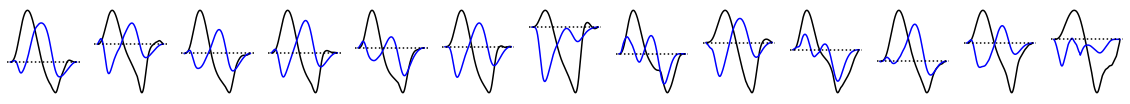

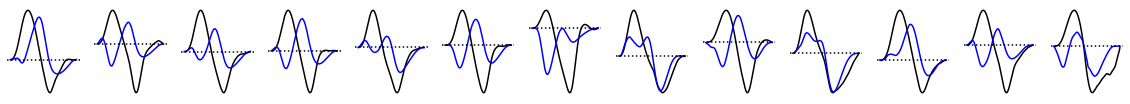

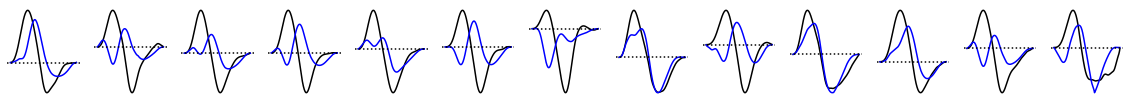

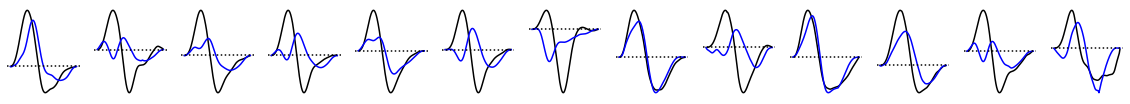

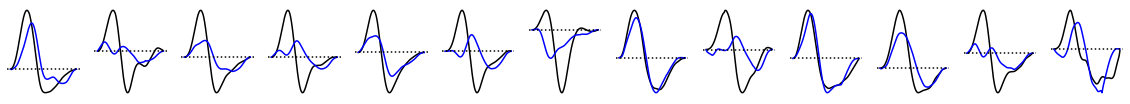

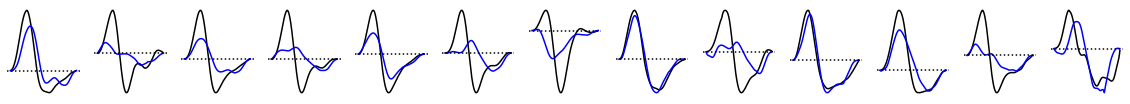

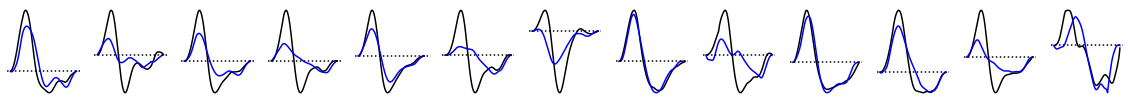

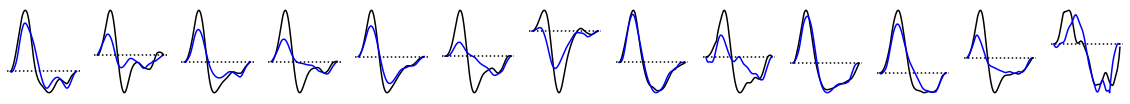

In [9]:
# run models
velocities = [250, 400, 600, 800, 1000, 1200, 1600, 2000]

dsi_all_all_looming_enhanced = np.zeros((len(velocities), 13))

for i, velocity in enumerate(velocities):
    dsi = convolved_dsis_looming_adjust(velocity, convolution_params)
    dsi_all_all_looming_enhanced[i, :] = dsi

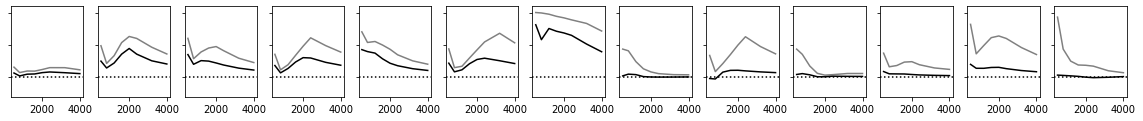

In [10]:
#Velocity tuning curve
fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
for i, clust in enumerate(ipl_depth_order):

    ax[i].plot(np.array(velocities)*2, dsi_all_all_looming_enhanced[:, clust], color='grey')
    ax[i].plot(np.array(velocities)*2, dsi_all_all_looming[:, clust], color='k')
    ax[i].set_ylim([-.3, 1.1])
    ax[i].axhline(color='k', linestyle='dotted')
    ax[i].set_yticklabels([])
#     ax[i].set_xticklabels([])
#     ax[i].axis('off')
# plt.legend()


# Figpath = 'Fig_temp/'
# savename = Figpath+"Velocity_tuning_clusters_looming_enhanced.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')
plt.show()

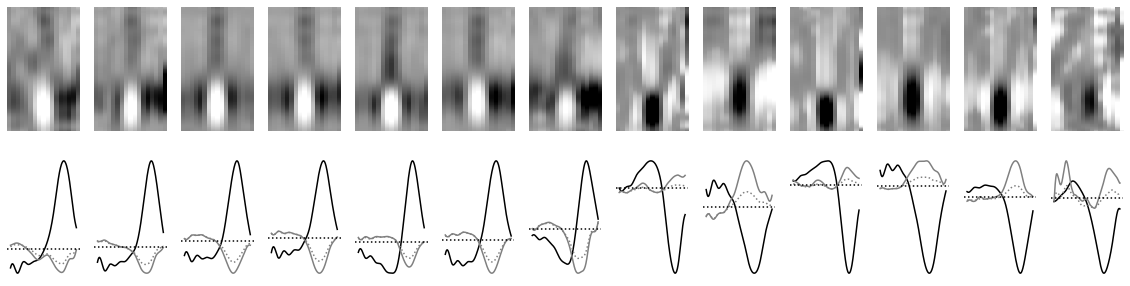

In [11]:
#plot of enhanced RFs and temporal kernels (non normalized)

polarity = [1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1]

fig, ax = plt.subplots(2, 13, figsize=(20, 5))
for i, clust in enumerate(ipl_depth_order):
    
#     ax[0, i].imshow(spline_array[quality_mask[0],:][s_df_xz_masked['new_cluster_assignment']==clust], aspect=12, cmap='Greys_r')
#     ax[0, i].set_yticklabels([])
#     ax[0, i].set_xticklabels([])
#     ax[0, i].axis('off')
    
    if polarity[clust]==-1:
        to_plot = average_filters[:,:,clust]
        to_plot = np.where(to_plot>0, to_plot*3, to_plot)
        to_plot[:, 18:21] = average_filters[:,18:21,clust] #turn this central part back into the normal
    else:
        to_plot = average_filters[:,:,clust]
        to_plot = np.where(to_plot<0, to_plot*3/2, to_plot)
        to_plot[:, 18:21] = average_filters[:,18:21,clust]
    
    ax[0, i].imshow(to_plot[15:-15,11:28]/np.linalg.norm(average_filters[50:-50,11:28,clust]), 
                    aspect='auto', cmap='Greys_r', vmin=-0.05, vmax=0.05)
#     if i == 0:
#         ax[0, i].axvline(10-10, color='k', linestyle='dotted')
#         ax[0, i].axvline(16-10, color='k', linestyle='dotted')
#         ax[0, i].axvline(18-10, color='r', linestyle='dotted')
#         ax[0, i].axvline(20-10, color='r', linestyle='dotted')
    ax[0, i].axis('off')
    
    avg_filter_flipped = to_plot*polarity[clust] #deal with off cells

    ax[1, i].plot(polarity[clust]*np.mean(avg_filter_flipped[15:-15,18:21], axis=1), color = 'k')#/np.amax(np.mean(avg_filter_flipped[100:-15,18:21], axis=1)), color='k',)
    ax[1, i].plot(polarity[clust]*np.mean(avg_filter_flipped[15:-15,11:17], axis=1), color = 'grey')#/np.amin(np.mean(avg_filter_flipped[150:-15,10:17], axis=1))*-1, color='grey')
    ax[1, i].plot(np.mean(average_filters[15:-15,10:17,clust], axis=1), color = 'grey', linestyle='dotted')
    #     ax[2].plot(np.mean(avg_filter_flipped[:,22:26], axis=1)/np.amin(np.mean(avg_filter_flipped[100:290,22:26], axis=1))*-1, color='b')
    ax[1, i].axhline(color='k', linestyle='dotted')
    ax[1, i].set_yticklabels([])
    ax[1, i].set_xticklabels([])
    ax[1, i].axis('off')
    
# Figpath = 'Fig_temp/'
# savename = Figpath+"Cluster_avgs_enhanced.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()

In [12]:
#PLOTTING STIMULUS
velocity = 1000

convolution_params['stimulus_velocity'] = velocity # WARNING altering this to play around with velocity tuning
convolution_params['distance_covered'] = 340
if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
    space_per_pixel = space_per_pixelx
else:
    space_per_pixel = space_per_pixely


time_px, space_px = get_svg_looming_stimulus(
    convolution_params['distance_covered'],
    convolution_params['stimulus_velocity'],
    real_time_lag,
    time_points,
    space_per_pixel
)

#On
string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
    <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
    <polygon points="{6},0 0,{7} {8},{9}" fill="white" />
</svg>""".format(space_px, time_px, space_px, time_px, space_px, time_px, 
                space_px/2, time_px, space_px, time_px)

folder_str = 'Data/'
file_name = str(1)
name_svg = folder_str + file_name + ".svg"
name_png = folder_str + file_name + ".png"

new_file = open(name_svg, "wt")
new_file.write(string_svg)
new_file.close()

cairosvg.svg2png(url=name_svg, write_to=name_png)

stimulus_image_On = np.array(Image.open(name_png).convert('L'))
stimulus_image_On_rev = np.flip(stimulus_image_On, axis=0)

#Off

stimulus_image_Off = stimulus_image_On * -1
stimulus_image_Off_rev = np.flip(stimulus_image_Off, axis=0)

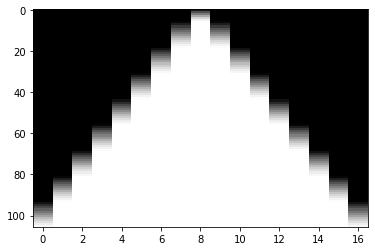

In [13]:
plt.imshow(stimulus_image_On, cmap='Greys_r', aspect='auto')


# Figpath = 'Fig_temp/'
# savename = Figpath+"Stimulus_image_looming_outward_on.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

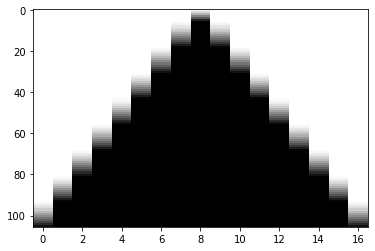

In [14]:
plt.imshow(stimulus_image_Off, cmap='Greys_r', aspect='auto')


# Figpath = 'Fig_temp/'
# savename = Figpath+"Stimulus_image_looming_outward_off.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')